In [1]:
from torch.autograd import graph

class SaveHook:
    def __init__(self):
        self.total_size = 0
        self.existing = set()

    def pack(self, tensor):            # called when a tensor is saved
        print("-- saving", tensor.shape, tensor.dtype, tensor.device, tensor.numel() * tensor.element_size())
        address = tensor.untyped_storage().data_ptr()
        if address not in self.existing:
            self.total_size += tensor.numel() * tensor.element_size()
            self.existing.add(address)
        return tensor            # return whatever object you want stored

    def unpack(self, obj):             # called when it is needed in backward
        return obj               # give the real tensor back


In [2]:
import torch

# Recursively walk the whole graph if you wish:

class GradientWalker:
    def __init__(self, existing: set[int] | None = None):
        self.existing = existing if existing is not None else set()
        self.total = 0

    def walk(self, fn, seen=None):
        seen = seen if seen is not None else set()
        if fn is None or fn in seen:
            return
        seen.add(fn)
        printed = False
        for name in dir(fn):
            if name.startswith("_saved_"):
                obj = getattr(fn, name)
                if isinstance(obj, torch.Tensor):
                    size = obj.numel() * obj.element_size()
                    if not printed:
                        print("-", fn.name())
                        printed = True
                    address = obj.untyped_storage().data_ptr()
                    print("--", name, obj.shape, obj.dtype, obj.device, size, '' if address not in self.existing else "(exists)")
                    if address not in self.existing:
                        self.total += size
                        self.existing.add(address)
        for nxt, _ in fn.next_functions:
            self.walk(nxt)


In [3]:
import torch
# import torchlens as tl

from cs336_basics.transformer import RMSNorm, SwiGLU, Linear, MultiHeadSelfAttention

device = "mps"
d_model = 256
batch_size = 8
seq_len = 14

class MPSMemoryCounter:
    def __init__(self):
        self.initial_memory = torch.mps.current_allocated_memory()
        self.last_memory = self.initial_memory
        print("Initial memory: ", self.initial_memory)

    def calc(self, text: str) -> None:
        cur_memory = torch.mps.current_allocated_memory()
        print(f"{text}: {cur_memory} | Difference: {cur_memory - self.last_memory}")
        self.last_memory = cur_memory



mc = MPSMemoryCounter()
# layer = RMSNorm(d_model).to(device)
# layer = SwiGLU(d_model, d_model * 4, device=device)
layer = Linear(d_model, d_model).to(device)
layer = MultiHeadSelfAttention(d_model, 8, device=device)
mc.calc("After RMSNorm")
print("- RMSNorm size: ", sum(p.numel() for p in layer.parameters()) * 4)

input = torch.randn([batch_size, seq_len, d_model]).to(device)
mc.calc("After input")
print("- Input size: ", input.numel() * 4)

# model_history = tl.show_model_graph(layer, input)

hook = SaveHook()
with graph.saved_tensors_hooks(hook.pack, hook.unpack):
    output = layer(input)
print("-> Total in hook:", hook.total_size)
mc.calc("After calculation")
print("- Output size: ", output.numel() * 4)

print()
walker = GradientWalker({output.untyped_storage().data_ptr(), input.untyped_storage().data_ptr(), *[p.untyped_storage().data_ptr() for p in layer.parameters()]})
walker.walk(output.grad_fn)

print("-> Total:", walker.total)
print("-> Total with output:", walker.total + output.numel() * output.element_size())

Initial memory:  0
After RMSNorm: 1050624 | Difference: 1050624
- RMSNorm size:  1048576
After input: 1310720 | Difference: 260096
- Input size:  114688
-- saving torch.Size([1, 256, 112]) torch.float32 mps:0 114688
-- saving torch.Size([1, 256, 112]) torch.float32 mps:0 114688
-- saving torch.Size([1, 256, 112]) torch.float32 mps:0 114688
-- saving torch.Size([64, 32, 14]) torch.float32 mps:0 114688
-- saving torch.Size([64, 14, 32]) torch.float32 mps:0 114688
-- saving torch.Size([8, 8, 14, 14]) torch.bool mps:0 12544
-- saving torch.Size([8, 8, 14, 1]) torch.int64 mps:0 7168
-- saving torch.Size([8, 8, 14, 14]) torch.float32 mps:0 50176
-- saving torch.Size([8, 8, 14, 1]) torch.float32 mps:0 3584
-- saving torch.Size([8, 8, 14, 14]) torch.float32 mps:0 50176
-- saving torch.Size([64, 14, 32]) torch.float32 mps:0 114688
-- saving torch.Size([64, 14, 14]) torch.float32 mps:0 50176
-- saving torch.Size([1, 256, 112]) torch.float32 mps:0 114688
-- saving torch.Size([1, 256, 256]) torch.

In [ ]:
# RMSNorm: (input) + output + pow2
# SwiGLU: 

---

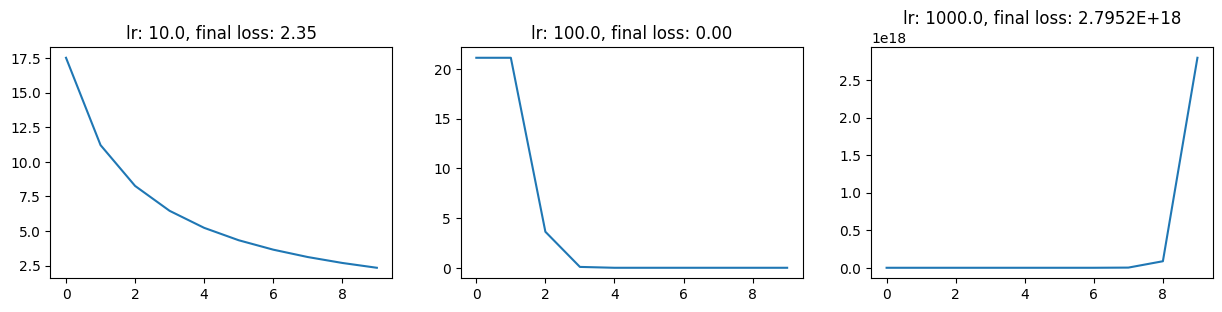

In [71]:
import torch
from cs336_basics.optimizer import SGD

def optimize(lr: int) -> list[float]:
    weights = torch.nn.Parameter(5 * torch.randn((10, 10)))
    loss_hist: list[float] = []
    opt = SGD([weights], lr=lr)
    for t in range(10):
        opt.zero_grad() # Reset the gradients for all learnable parameters.
        loss = (weights**2).mean() # Compute a scalar loss value.
        loss_hist.append(loss.cpu().item())
        loss.backward() # Run backward pass, which computes gradients.
        opt.step() # Run optimizer step.
    return loss_hist

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for ax, lr in zip(axs, [1e1, 1e2, 1e3]):
    loss_hist = optimize(lr=lr)
    ax.plot(loss_hist, label=lr)
    final_loss = f"{loss_hist[-1]:.2f}" if loss_hist[-1] < 100 else f"{loss_hist[-1]:.4E}"
    ax.set_title(f"lr: {lr}, final loss: {final_loss}")
plt.show()


In [2]:
from pprint import pprint

def get_flops(d_model: int, context_length: int, num_layers: int, vocab_size: int) -> dict[str, tuple[int, float]]:
	mhsa = num_layers * (8 * d_model + 2 * context_length + 2) * context_length * d_model
	swiglu = num_layers * (6 * d_model + 2) * context_length * 4 * d_model
	final_linear = 2 * context_length * d_model * vocab_size
	total = mhsa + swiglu + final_linear
	return {
	    "mhsa": (mhsa, mhsa / total),
	    "swiglu": (swiglu, swiglu / total),
	    "final_linear": (final_linear, final_linear / total),
	    "total": (total, total / total),
	}

common_params = {
    "vocab_size": 50257,
    "context_length": 1024,
}
models = {
    "small": {**common_params, "num_layers": 12, "d_model": 768},
    "medium": {**common_params, "num_layers": 24, "d_model": 1024},
    "large": {**common_params, "num_layers": 36, "d_model": 1280},
    "xl": {**common_params, "num_layers": 48, "d_model": 1600},
}

for model, params in models.items():
    print(model)
    pprint(get_flops(**params))
    print()

small
{'final_linear': (79047426048, 0.2392495513208068),
 'mhsa': (77328285696, 0.2340463008364237),
 'swiglu': (174021672960, 0.5267041478427695),
 'total': (330397384704, 1.0)}

medium
{'final_linear': (105396568064, 0.10734798758567952),
 'mhsa': (257748369408, 0.26252058551505975),
 'swiglu': (618676617216, 0.6301314268992607),
 'total': (981821554688, 1.0)}

large
{'final_linear': (131745710080, 0.06094853022322853),
 'mhsa': (579914956800, 0.26828170913469995),
 'swiglu': (1449928949760, 0.6707697606420715),
 'total': (2161589616640, 1.0)}

xl
{'final_linear': (164682137600, 0.03783133564028427),
 'mhsa': (1167851520000, 0.26828278691918167),
 'swiglu': (3020528025600, 0.693885877440534),
 'total': (4353061683200, 1.0)}

